# Coffee and milk analysis

The goal of this notebook is to identify the optimal time to add milk to coffee to minimize the time for the coffee to reach an optimal temperature.

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import pint

Define a [`pint`](https://pint.readthedocs.io/en/stable/index.html) [UnitRegistry](https://pint.readthedocs.io/en/stable/tutorial.html):

In [2]:
ureg = pint.UnitRegistry()

Define an output directory:

In [3]:
results_path = Path.cwd() / "results"

## Assumptions

The initial temperature of the coffee is 100°C:

In [4]:
T0_coffee = ureg.Quantity(100, ureg.degC)

The initial temperature of the milk is 4°C ([ideal refridgerator temperature](https://www.fda.gov/consumers/consumer-updates/are-you-storing-food-safely)):

In [5]:
T0_milk = ureg.Quantity(4, ureg.degC)

The ambient temperature is 20°C:

In [6]:
T_ambient = ureg.Quantity(20, ureg.degC)

"Comfortable" drinking temperature is 80°C ([source](https://www.coffeedetective.com/what-is-the-correct-temperature-for-serving-coffee.html)):

In [7]:
T_ideal = ureg.Quantity(80, ureg.degC)

The heat capacity of the coffee is the same as that of water (4.184 J/g°K):

In [8]:
heat_capacity_coffee = 4.184 * ureg.J / ureg.g / ureg.K

The heat capacity of the milk is 3.93 J/g°K ([source](https://www.engineeringtoolbox.com/specific-heat-fluids-d_151.html)):

In [9]:
heat_capacity_milk = 3.93 * ureg.J / ureg.g / ureg.K

The mug inner diameter is 70 mm (82 mm - 2 * 6mm; see [this opinionated post](http://blog.ampli.fi/the-standard-coffee-mug-dimensions/) for coffee mug dimensions):

In [10]:
area_mug = np.pi * ((70 * ureg.mm) / 2) ** 2

Note that we will assume the mug is well-insulated, so the only heat loss of the mug comes from radiative cooling from the liquid surface to ambient.

The mug height is 95 mm (same as above source), but let's say the mug is filled to 80% of capacity:

In [11]:
filled_height_mug = 0.8 * 95 * ureg.mm

The filled volume of the mug, aka the filled volume of coffee, can be calculated:

In [12]:
volume_coffee = area_mug * filled_height_mug
volume_coffee

292482.27604920976 <Unit('millimeter ** 3')>

This is ~10 fluid ounces ([WolframAlpha](https://www.wolframalpha.com/input/?i=292482.27604920976+millimeter3+to+ounces)), which sounds about right.

The density of coffee is equivalent to that of water:

In [13]:
density_coffee = 1 * ureg.g / ureg.mL

Calculate the mass of the coffee:

In [14]:
mass_coffee = (volume_coffee * density_coffee).to_base_units()
mass_coffee

0.29248227604920973 <Unit('kilogram')>

For a slightly controversial question: how much milk to add to the coffee? Starbucks allows a user to add a ["splash"](https://www.starbucks.com/menu/product/480/hot?parent=%2Fdrinks%2Fhot-coffees%2Fbrewed-coffees) of milk as a default option. From [this source](https://www.mirror.co.uk/news/uk-news/experts-reveal-difference-between-splash-12398376), a "splash" is 5 mL.

In [15]:
volume_milk = 5 * ureg.mL

The density of milk is just above that of water ([source](https://www.theengineer.co.uk/supplier-network/product/density-measurement-of-milk-and-dairy-products/)):

In [16]:
density_milk = 1.03 * ureg.g / ureg.mL

Calculate the mass of milk:

In [17]:
mass_milk = (volume_milk * density_milk).to_base_units()
mass_milk.to("g")

5.15 <Unit('gram')>

To start, assume black coffee with an emmissivity of 1:

In [18]:
emmissivity_coffee = 1

Assume coffee with milk has an emmissivity of 0.9 (arbitrary, but not aware of better ideas):

In [19]:
emmissivity_coffee_with_milk = 0.9

Define simulation runtime and time step size:

In [20]:
time_final = 8 * ureg.hr
time_step = 10 * ureg.s

## Set up physical expressions

To start, let's just model the temperature of a coffee mug exposed to ambient air. Again, we assume the only source of heat loss comes from radiative cooling between the exposed liquid and ambient.

The radiative heat loss rate is given by Equation 3 of [this source](https://www.engineeringtoolbox.com/radiation-heat-transfer-d_431.html):

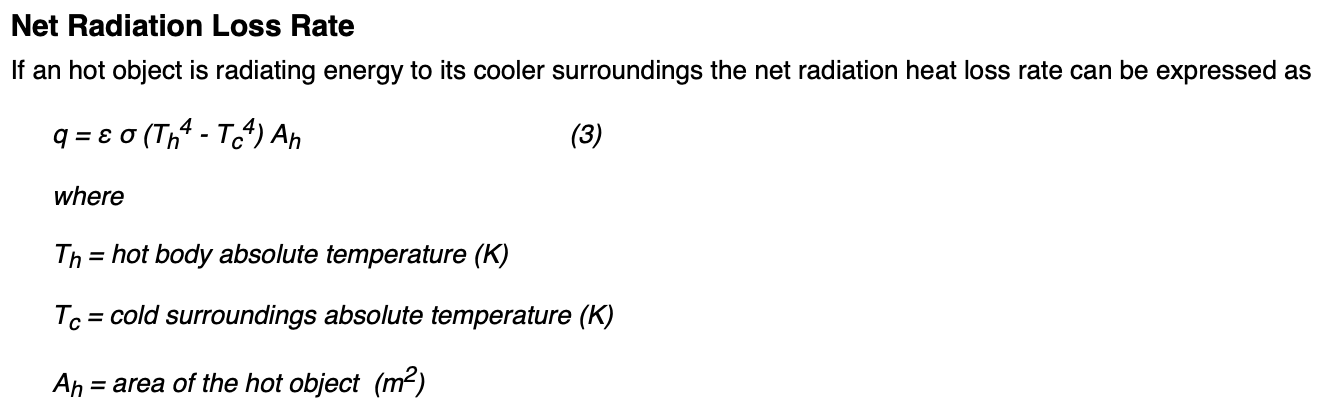

Define the Stefan-Boltzmann constant from `pint`:

In [21]:
SBC = ureg.stefan_boltzmann_constant

Calculate radiative heat loss rate:

In [22]:
def calculate_radiative_heat_loss_rate(emmissivity, SBC, T_mug, T_ambient, area_mug):
    radiative_heat_loss_rate = emmissivity * SBC * (T_mug.to("degK") ** 4 - T_ambient.to("degK") ** 4) * area_mug
    return radiative_heat_loss_rate

The change in temperature is given by the classic equation $Q=mc\Delta T$ (ignoring a temperature dependence of the heat capacity):

In [23]:
def calculate_deltaT(heat_loss, mass, heat_capacity):
    deltaT = heat_loss / (mass * heat_capacity)
    return deltaT

Eventually, we'll also need to calculate deltaT for a mixture. For this calculation, we simply estimate a new heat capacity based on a weighted heat capacity of the system components:

In [24]:
def calculate_deltaT_mixture(heat_loss, mass1, mass2, heat_capacity1, heat_capacity2):
    total_mass = mass1 + mass2
    heat_capacity_mixture = (mass1 / total_mass) * heat_capacity1 + (mass2 / total_mass) * heat_capacity2
    deltaT = heat_loss / (total_mass * heat_capacity_mixture)
    return deltaT

Initialize a time vector and temperature vector:

In [25]:
time_vector = np.arange(0, time_final.to("s").magnitude, time_step.to("s").magnitude) * ureg.s
temperature_vector = np.zeros(time_vector.shape) * ureg.degC

Loop through time and record time when temperature reaches ideal drinking temperature:

In [26]:
time_to_ideal_temperature = -1

for k, time in enumerate(time_vector):
    
    if time == 0:
        temperature_vector[0] = T0_coffee
    else:
        radiative_heat_loss_rate = calculate_radiative_heat_loss_rate(emmissivity_coffee,
                                                                      SBC, temperature_vector[k-1],
                                                                      T_ambient, area_mug)
        radiative_heat_loss = radiative_heat_loss_rate * time_step
        deltaT = calculate_deltaT(radiative_heat_loss, mass_coffee, heat_capacity_coffee)
        temperature_vector[k] = temperature_vector[k-1] - deltaT.to("delta_degC")
        
        if time_to_ideal_temperature == -1 and temperature_vector[k] < T_ideal:
            time_to_ideal_temperature = time

Plot results:

/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


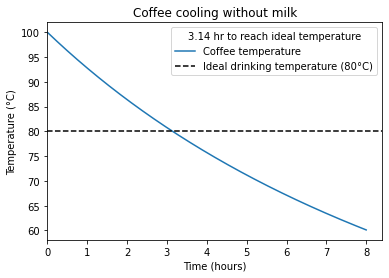

In [27]:
T_ideal_degC = T_ideal.to("degC").magnitude
time_to_ideal_temperature_hr = time_to_ideal_temperature.to("hr").magnitude

plt.plot(time_vector.to("hours"), temperature_vector.to("degC"), label="Coffee temperature")
plt.axhline(T_ideal_degC, label=f"Ideal drinking temperature ({T_ideal_degC}°C)", color="k", ls="--")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.xlim(left=0)
plt.legend(title=f"{time_to_ideal_temperature_hr:.2f} hr to reach ideal temperature")
plt.title("Coffee cooling without milk")
plt.savefig(results_path / "coffee_no_milk.png", dpi=300, bbox_inches="tight")

Cooling is slower than I would expect, but overall the trend is reasonable. Perhaps additional sources of cooling (convection, nonadiabicity of the mug) would account for this difference.

## Coffee with milk
Now, we model coffee with milk added at some time. Assume some arbitrary time to start:

In [28]:
t_milk_insertion = 1 * ureg.hr

Preinitialize, as before:

In [29]:
time_vector = np.arange(0, time_final.to("s").magnitude, time_step.to("s").magnitude) * ureg.s
temperature_vector = np.zeros(time_vector.shape) * ureg.degC

Loop through time and record time when temperature reaches ideal drinking temperature:

In [30]:
time_to_ideal_temperature = -1
has_milk_been_added_yet = False

for k, time in enumerate(time_vector):
    
    # Initial condition
    if time == 0:
        temperature_vector[0] = T0_coffee
        
    # Just coffee cooling
    elif time < t_milk_insertion:
        radiative_heat_loss_rate = calculate_radiative_heat_loss_rate(emmissivity_coffee,
                                                                      SBC, temperature_vector[k-1],
                                                                      T_ambient, area_mug)
        radiative_heat_loss = radiative_heat_loss_rate * time_step
        deltaT = calculate_deltaT(radiative_heat_loss, mass_coffee, heat_capacity_coffee)
        temperature_vector[k] = temperature_vector[k-1] - deltaT.to("delta_degC")
        
    # Coffee with milk
    else:
        # Account for instantaneous change in temperature.
        # Skip radiative cooling for this timestep, assume your hand/milk jug insulates the exposed area.
        if not has_milk_been_added_yet:
            thermal_mass_coffee = mass_coffee * heat_capacity_coffee
            thermal_mass_milk = mass_milk * heat_capacity_milk
            total_thermal_mass = thermal_mass_coffee + thermal_mass_milk
            temperature_vector[k] = ((thermal_mass_coffee * temperature_vector[k-1].to("degK") + 
                                     thermal_mass_milk * T0_milk.to("degK")) / total_thermal_mass).to("degC")
            has_milk_been_added_yet = True
        
        # After milk has been added, proceed as before but account for mixture properties
        else:
            radiative_heat_loss_rate = calculate_radiative_heat_loss_rate(emmissivity_coffee_with_milk,
                                                                          SBC, temperature_vector[k-1],
                                                                          T_ambient, area_mug)
            radiative_heat_loss = radiative_heat_loss_rate * time_step
            deltaT = calculate_deltaT_mixture(radiative_heat_loss, mass_coffee, mass_milk,
                                              heat_capacity_coffee, heat_capacity_milk)
            temperature_vector[k] = temperature_vector[k-1] - deltaT.to("delta_degC")
        
    if time_to_ideal_temperature == -1 and temperature_vector[k] < T_ideal:
        time_to_ideal_temperature = time

Plot results:

/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


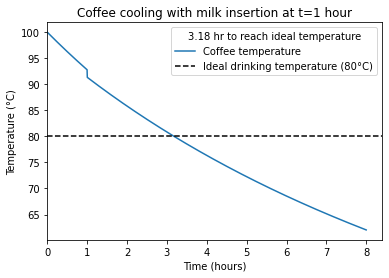

In [31]:
T_ideal_degC = T_ideal.to("degC").magnitude
time_to_ideal_temperature_hr = time_to_ideal_temperature.to("hr").magnitude

plt.plot(time_vector.to("hours"), temperature_vector.to("degC"), label="Coffee temperature")
plt.axhline(T_ideal_degC, label=f"Ideal drinking temperature ({T_ideal_degC}°C)", color="k", ls="--")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.xlim(left=0)
plt.legend(title=f"{time_to_ideal_temperature_hr:.2f} hr to reach ideal temperature")
plt.title(f"Coffee cooling with milk insertion at t={t_milk_insertion}")
plt.savefig(results_path / "coffee_withmilk_1hr.png", dpi=300, bbox_inches="tight")

The result looks reasonable, but the small change in temperature indicates that the additional milk probably doesn't make a big difference.

## Optimize milk insertion temperature

Here, we loop through a variety of milk insertion times to identify the optimum.

In [32]:
milk_insertion_times = np.arange(0, 4, 0.25) * ureg.hr

Preinitialize, as before but with an extra dimension for `temperature_vector`:

In [33]:
time_vector = np.arange(0, time_final.to("s").magnitude, time_step.to("s").magnitude) * ureg.s
temperature_array = np.zeros((len(milk_insertion_times), len(time_vector))) * ureg.degC
time_to_ideal_temperature_vector = -1 * np.ones((len(milk_insertion_times), )) * ureg.s

Loop through time and record time when temperature reaches ideal drinking temperature:

In [34]:
for k1, t_milk_insertion in enumerate(milk_insertion_times):
    
    print(f"Starting simulation {k1 + 1}/{len(milk_insertion_times)}")
    
    has_milk_been_added_yet = False

    for k2, time in enumerate(time_vector):

        # Initial condition
        if time == 0:
            temperature_array[k1, 0] = T0_coffee

        # Just coffee cooling
        elif time < t_milk_insertion:
            radiative_heat_loss_rate = calculate_radiative_heat_loss_rate(emmissivity_coffee,
                                                                          SBC, temperature_array[k1, k2-1],
                                                                          T_ambient, area_mug)
            radiative_heat_loss = radiative_heat_loss_rate * time_step
            deltaT = calculate_deltaT(radiative_heat_loss, mass_coffee, heat_capacity_coffee)
            temperature_array[k1, k2] = temperature_array[k1, k2 - 1] - deltaT.to("delta_degC")

        # Coffee with milk
        else:
            # Account for instantaneous change in temperature.
            # Skip radiative cooling for this timestep, assume your hand/milk jug insulates the exposed area.
            if not has_milk_been_added_yet:
                thermal_mass_coffee = mass_coffee * heat_capacity_coffee
                thermal_mass_milk = mass_milk * heat_capacity_milk
                total_thermal_mass = thermal_mass_coffee + thermal_mass_milk
                temperature_array[k1, k2] = ((thermal_mass_coffee * temperature_array[k1, k2 - 1].to("degK") + 
                                              thermal_mass_milk * T0_milk.to("degK")) / total_thermal_mass).to("degC")
                has_milk_been_added_yet = True

            # After milk has been added, proceed as before but account for mixture properties
            else:
                radiative_heat_loss_rate = calculate_radiative_heat_loss_rate(emmissivity_coffee_with_milk,
                                                                              SBC, temperature_array[k1, k2 - 1],
                                                                              T_ambient, area_mug)
                radiative_heat_loss = radiative_heat_loss_rate * time_step
                deltaT = calculate_deltaT_mixture(radiative_heat_loss, mass_coffee, mass_milk,
                                                  heat_capacity_coffee, heat_capacity_milk)
                temperature_array[k1, k2] = temperature_array[k1, k2 - 1] - deltaT.to("delta_degC")
        
        if time_to_ideal_temperature_vector[k1].to("s").magnitude == -1 and temperature_array[k1, k2] < T_ideal:
            time_to_ideal_temperature_vector[k1] = time

Starting simulation 1/16
Starting simulation 2/16
Starting simulation 3/16
Starting simulation 4/16
Starting simulation 5/16
Starting simulation 6/16
Starting simulation 7/16
Starting simulation 8/16
Starting simulation 9/16
Starting simulation 10/16
Starting simulation 11/16
Starting simulation 12/16
Starting simulation 13/16
Starting simulation 14/16
Starting simulation 15/16
Starting simulation 16/16


Plot all temperature profiles:

/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when

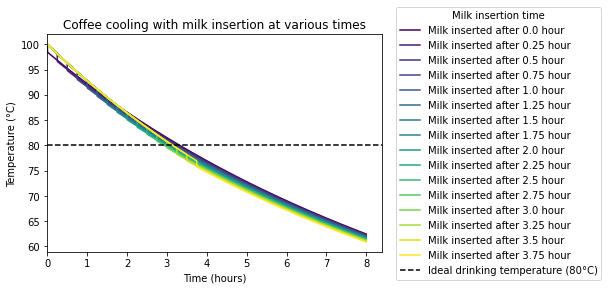

In [35]:
colors = cm.get_cmap('viridis')(np.linspace(0, 1, len(milk_insertion_times)))

for k, temperature_vector in enumerate(temperature_array):
    plt.plot(time_vector.to("hr"), temperature_vector.to("degC"), 
            color=colors[k], label=f"Milk inserted after {milk_insertion_times[k]}")
    
plt.axhline(T_ideal_degC, label=f"Ideal drinking temperature ({T_ideal_degC}°C)",
            color="k", ls="--")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.xlim(left=0)
plt.legend(title="Milk insertion time", bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.title(f"Coffee cooling with milk insertion at various times")
plt.savefig(results_path / "coffee_withmilk_alltimes.png", dpi=300, bbox_inches="tight")

Plot time to reach ideal temperature vs. milk insertion time:

/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


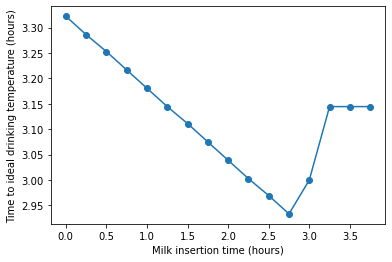

In [36]:
plt.plot(milk_insertion_times, time_to_ideal_temperature_vector.to("hr"), '-o')
plt.xlabel("Milk insertion time (hours)")
plt.ylabel("Time to ideal drinking temperature (hours)")
plt.savefig(results_path / "t_ideal_vs_t_insertion.png", dpi=300, bbox_inches="tight")

Interestingly, we observe a linear trend. The plot levels off at the end because if you wait too long, the coffee would have already naturally cooled to the comfortable drinking temperature.

View raw values:

In [37]:
time_to_ideal_temperature_vector.to("min")

Magnitude,[199.33333333333334 197.16666666666666 195.16666666666666 193.0 190.83333333333334 188.66666666666666 186.66666666666666 184.5 182.33333333333334 180.16666666666666 178.16666666666666 176.0 180.0 188.66666666666666 188.66666666666666 188.66666666666666]
Units,minute


## What role does the emmissivity play?

In the above simulation, we assumed that the emmissivity changed from `1` to `0.9` upon the addition of milk. Does this effect actually matter?

Preinitialize, per usual:

In [38]:
time_vector = np.arange(0, time_final.to("s").magnitude, time_step.to("s").magnitude) * ureg.s
temperature_array = np.zeros((len(milk_insertion_times), len(time_vector))) * ureg.degC
time_to_ideal_temperature_vector = -1 * np.ones((len(milk_insertion_times), )) * ureg.s

Loop through time and record time when temperature reaches ideal drinking temperature:

In [39]:
for k1, t_milk_insertion in enumerate(milk_insertion_times):
    
    print(f"Starting simulation {k1 + 1}/{len(milk_insertion_times)}")
    
    has_milk_been_added_yet = False

    for k2, time in enumerate(time_vector):

        # Initial condition
        if time == 0:
            temperature_array[k1, 0] = T0_coffee

        # Just coffee cooling
        elif time < t_milk_insertion:
            radiative_heat_loss_rate = calculate_radiative_heat_loss_rate(emmissivity_coffee,
                                                                          SBC, temperature_array[k1, k2-1],
                                                                          T_ambient, area_mug)
            radiative_heat_loss = radiative_heat_loss_rate * time_step
            deltaT = calculate_deltaT(radiative_heat_loss, mass_coffee, heat_capacity_coffee)
            temperature_array[k1, k2] = temperature_array[k1, k2 - 1] - deltaT.to("delta_degC")

        # Coffee with milk
        else:
            # Account for instantaneous change in temperature.
            # Skip radiative cooling for this timestep, assume your hand/milk jug insulates the exposed area.
            if not has_milk_been_added_yet:
                thermal_mass_coffee = mass_coffee * heat_capacity_coffee
                thermal_mass_milk = mass_milk * heat_capacity_milk
                total_thermal_mass = thermal_mass_coffee + thermal_mass_milk
                temperature_array[k1, k2] = ((thermal_mass_coffee * temperature_array[k1, k2 - 1].to("degK") + 
                                              thermal_mass_milk * T0_milk.to("degK")) / total_thermal_mass).to("degC")
                has_milk_been_added_yet = True

            # After milk has been added, proceed as before but account for mixture properties
            else:
                radiative_heat_loss_rate = calculate_radiative_heat_loss_rate(emmissivity_coffee,
                                                                              SBC, temperature_array[k1, k2 - 1],
                                                                              T_ambient, area_mug)
                radiative_heat_loss = radiative_heat_loss_rate * time_step
                deltaT = calculate_deltaT_mixture(radiative_heat_loss, mass_coffee, mass_milk,
                                                  heat_capacity_coffee, heat_capacity_milk)
                temperature_array[k1, k2] = temperature_array[k1, k2 - 1] - deltaT.to("delta_degC")
        
        if time_to_ideal_temperature_vector[k1].to("s").magnitude == -1 and temperature_array[k1, k2] < T_ideal:
            time_to_ideal_temperature_vector[k1] = time

Starting simulation 1/16
Starting simulation 2/16
Starting simulation 3/16
Starting simulation 4/16
Starting simulation 5/16
Starting simulation 6/16
Starting simulation 7/16
Starting simulation 8/16
Starting simulation 9/16
Starting simulation 10/16
Starting simulation 11/16
Starting simulation 12/16
Starting simulation 13/16
Starting simulation 14/16
Starting simulation 15/16
Starting simulation 16/16


Plot all temperature profiles:

/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when

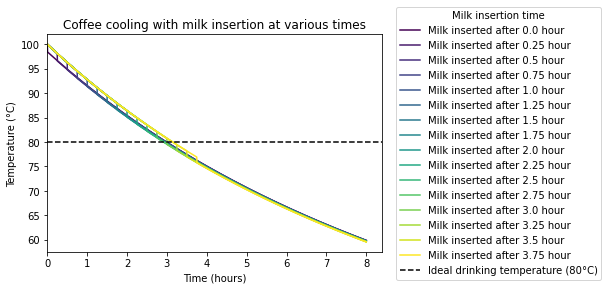

In [40]:
colors = cm.get_cmap('viridis')(np.linspace(0, 1, len(milk_insertion_times)))

for k, temperature_vector in enumerate(temperature_array):
    plt.plot(time_vector.to("hr"), temperature_vector.to("degC"), 
            color=colors[k], label=f"Milk inserted after {milk_insertion_times[k]}")
    
plt.axhline(T_ideal_degC, label=f"Ideal drinking temperature ({T_ideal_degC}°C)",
            color="k", ls="--")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.xlim(left=0)
plt.legend(title="Milk insertion time", bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.title(f"Coffee cooling with milk insertion at various times")
plt.savefig(results_path / "coffee_withmilk_alltimes_constantemmissivity.png", dpi=300, bbox_inches="tight")

Plot time to reach ideal temperature vs. milk insertion time:

/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


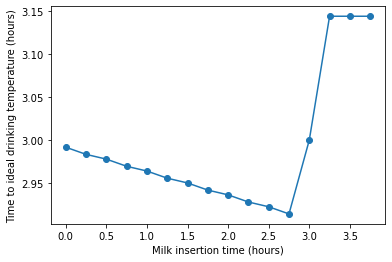

In [41]:
plt.plot(milk_insertion_times, time_to_ideal_temperature_vector.to("hr"), '-o')
plt.xlabel("Milk insertion time (hours)")
plt.ylabel("Time to ideal drinking temperature (hours)")
plt.savefig(results_path / "t_ideal_vs_t_insertion_constantemmissivity.png", dpi=300, bbox_inches="tight")

Again, we observe a linear trend.

View raw values:

In [42]:
time_to_ideal_temperature_vector.to("min")

Magnitude,[179.5 179.0 178.66666666666666 178.16666666666666 177.83333333333334 177.33333333333334 177.0 176.5 176.16666666666666 175.66666666666666 175.33333333333334 174.83333333333334 180.0 188.66666666666666 188.66666666666666 188.66666666666666]
Units,minute


## Conclusions

Perhaps counterintuitively, the best time to insert your milk into your coffee is after it has cooled for some time. This is because the radiative heat transfer is fastest when the temperature gradient between the coffee and ambient is largest, which occurs in the beginning of the cooling process. However, the difference between the most extreme values (176 minutes vs 199.3 minutes) is 23.3 minutes (for the variable emmissivity case), which is pretty small overall given the conservative cooling times used in these simulations.

The change in emmissivity does make a small difference; adding the milk in later is penalized slightly more.